In [1]:
import matplotlib
import numpy as np
import os
import sys
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import colors
from hydra import initialize, compose
import pickle
from glob import glob
from pprint import pprint
from tqdm import tqdm
from astropy.cosmology import default_cosmology

from lenstronomy.Data.pixel_grid import PixelGrid
from lenstronomy.Data.psf import PSF
from lenstronomy.ImSim.image_model import ImageModel
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LightModel.light_model import LightModel
from lenstronomy.SimulationAPI.ObservationConfig import Roman
from lenstronomy.Util import data_util

# set paths to various directories based on the machine this code is being executed on
with initialize(version_base=None, config_path='config'):
    config = compose(config_name='config.yaml')  # overrides=['machine=uzay']

array_dir, data_dir, figure_dir, pickle_dir, repo_dir = config.machine.array_dir, config.machine.data_dir, config.machine.figure_dir, config.machine.pickle_dir, config.machine.repo_dir

# enable use of local modules
if repo_dir not in sys.path:
    sys.path.append(repo_dir)

# set matplotlib style
plt.style.use(f'{repo_dir}/mejiro/mplstyle/science.mplstyle')

from mejiro.utils import util
from mejiro.helpers import survey_sim

In [2]:
total_lens_population = util.unpickle(os.path.join(config.machine.dir_00, 'total_lens_population.pkl'))

In [7]:
snr_lists, overall_snrs = [], []
for gglens in tqdm(total_lens_population):
    snr_list, overall_snr = survey_sim.get_snr(gglens, band='F129', num_pix=45, side=4.95, oversample=1,
                                               return_snr_list=True, debugging=False)
    snr_lists.append(snr_list)
    overall_snrs.append(overall_snr)

100%|██████████| 734/734 [04:12<00:00,  2.91it/s]


In [9]:
overall_is_highest = 0
for overall_snr, snr_list in zip(overall_snrs, snr_lists):
    if overall_snr == np.max(snr_list):
        overall_is_highest += 1

print(
    f'Overall SNR is highest in {overall_is_highest} out of {len(overall_snrs)} cases, or {100 * overall_is_highest / len(overall_snrs):.2f}%.')

Overall SNR is highest in 672 out of 734 cases, or 91.55%.


In [2]:
snr_pickles = glob(f'{config.machine.dir_00}/masked_snr_array_snr_*.pkl')
snr_masked_array_pickles = glob(f'{config.machine.dir_00}/masked_snr_array_00*.pkl')

snr_list = [util.unpickle(p) for p in snr_pickles]
snr_masked_array_list = [util.unpickle(p) for p in snr_masked_array_pickles]

In [3]:
figure_output_dir = os.path.join(data_dir, 'snr_estimate')
util.create_directory_if_not_exists(figure_output_dir)
util.clear_directory(figure_output_dir)

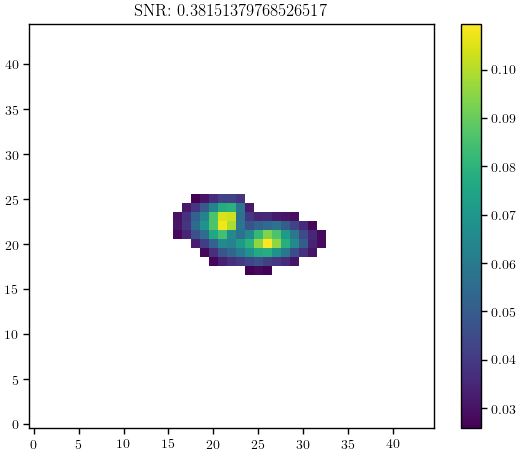

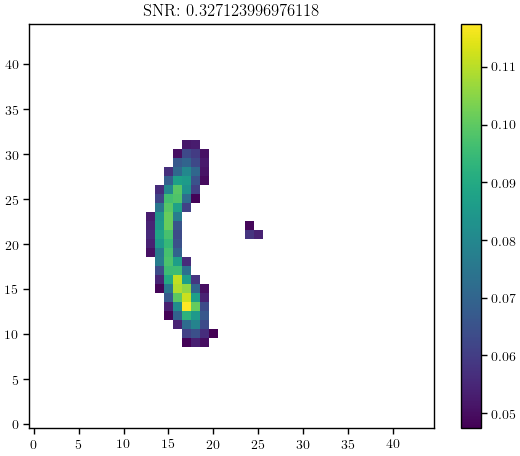

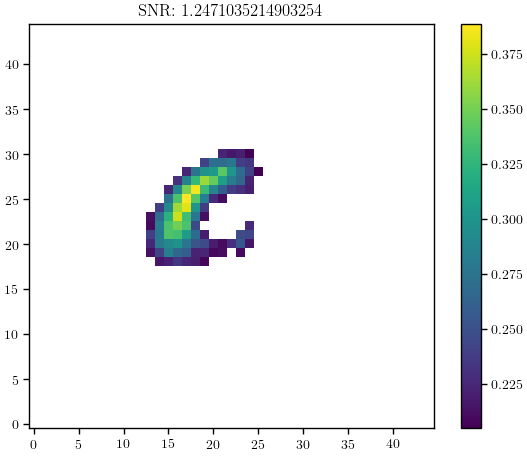

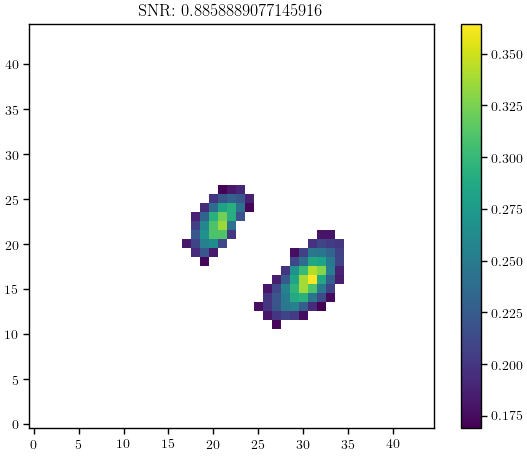

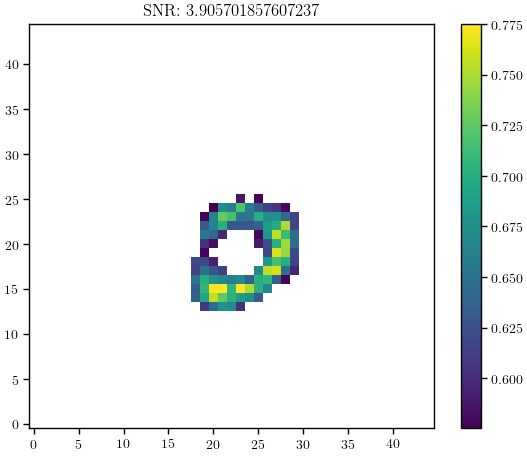

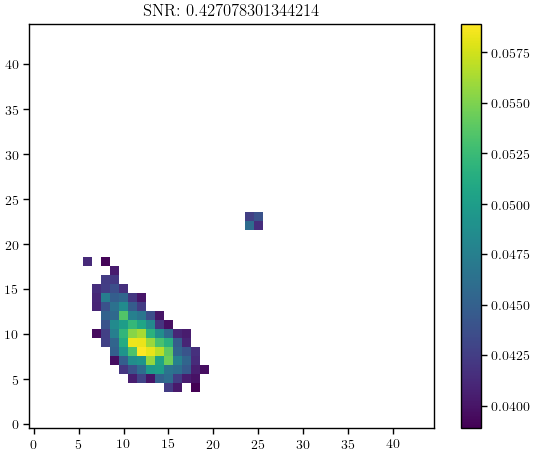

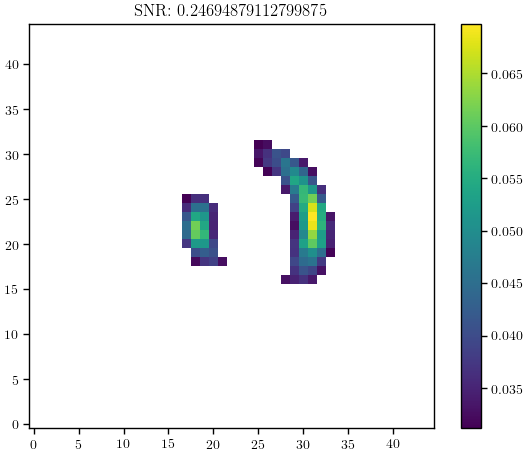

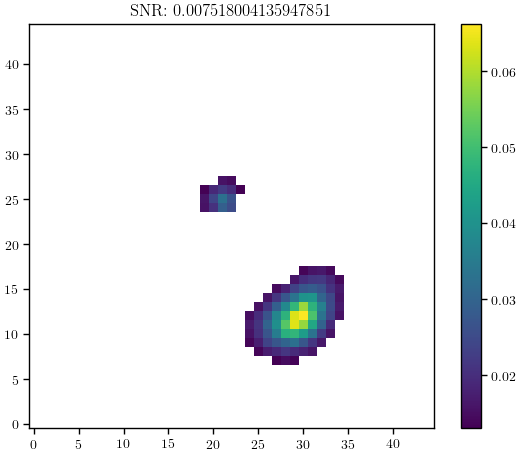

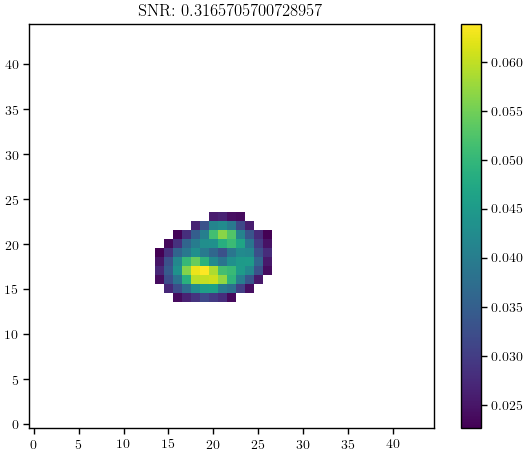

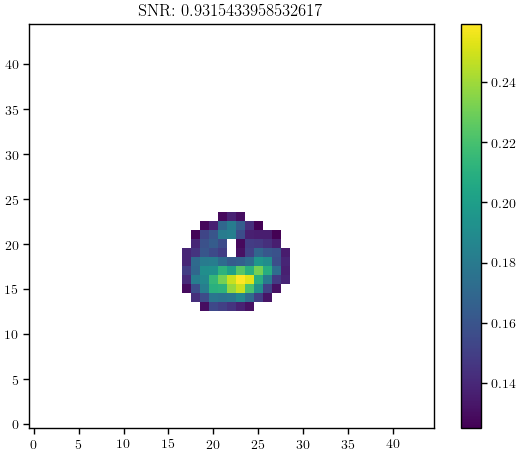

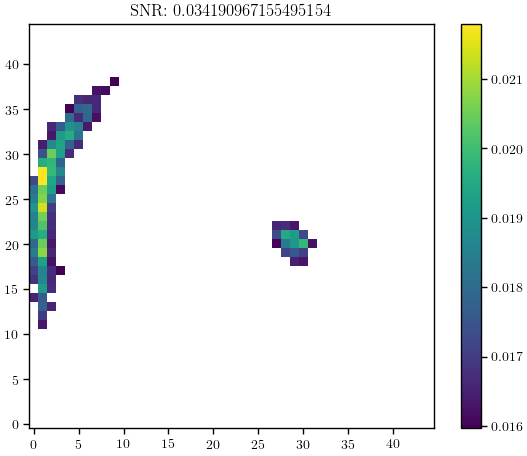

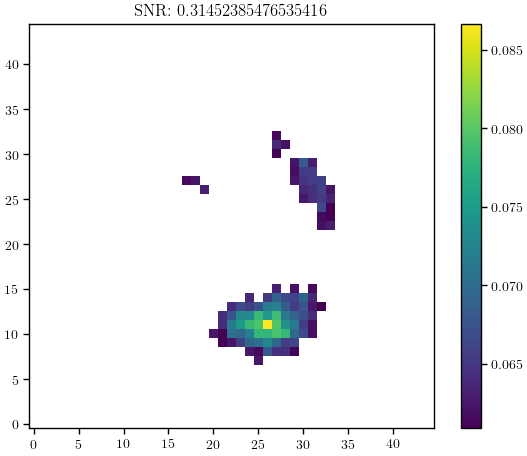

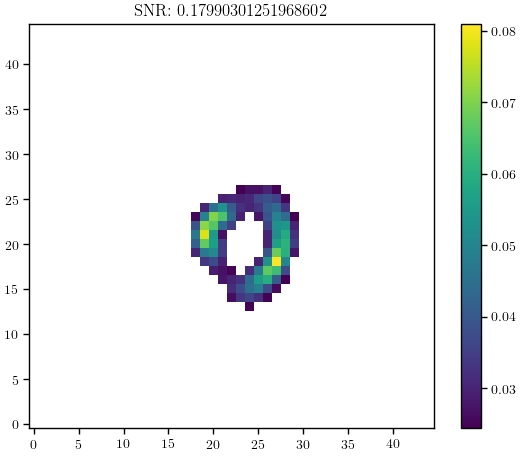

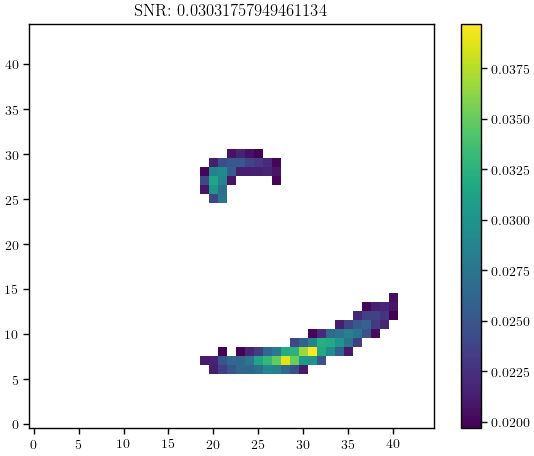

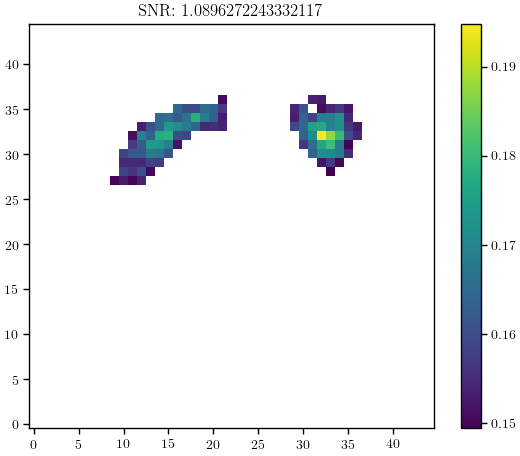

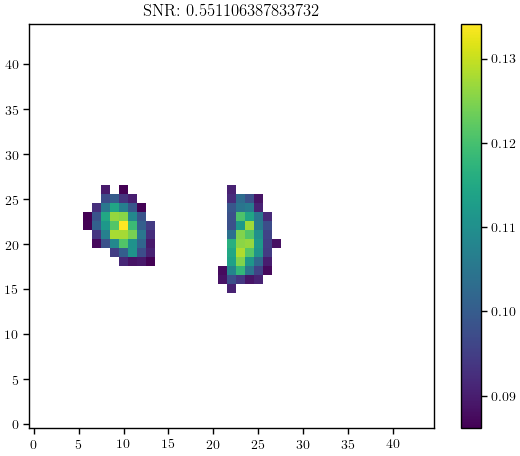

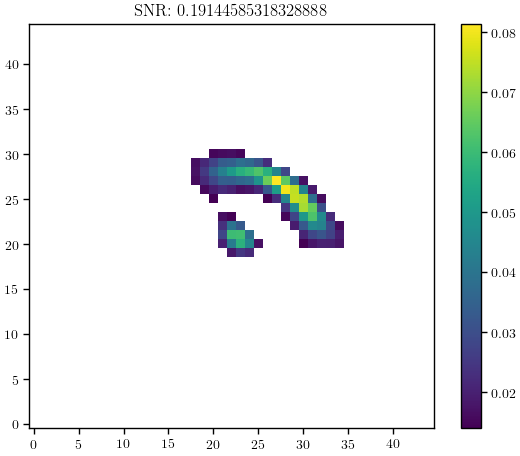

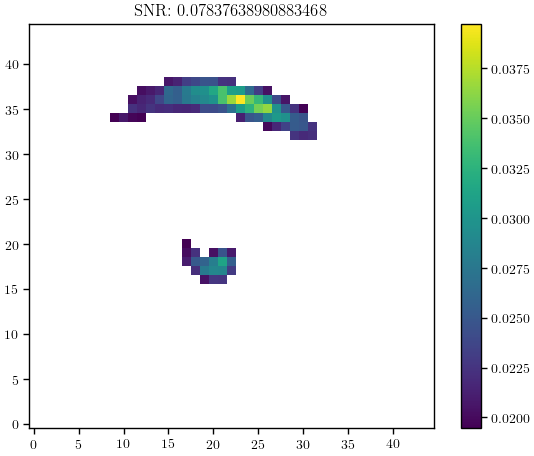

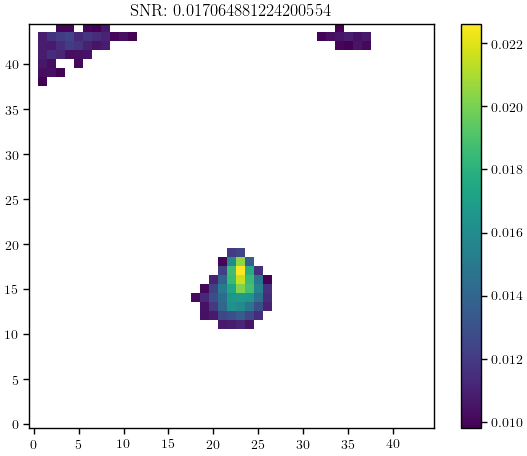

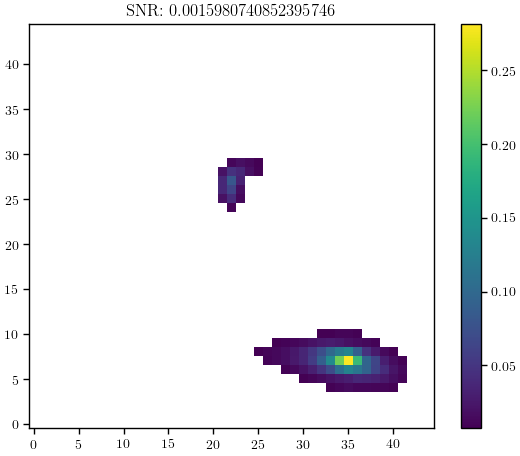

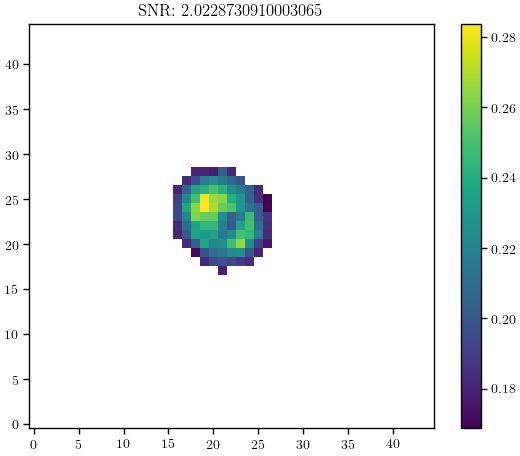

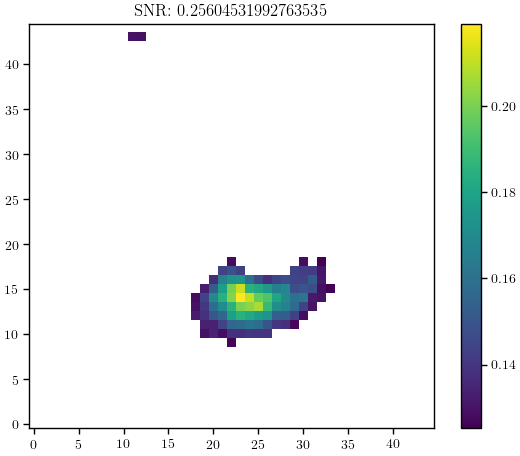

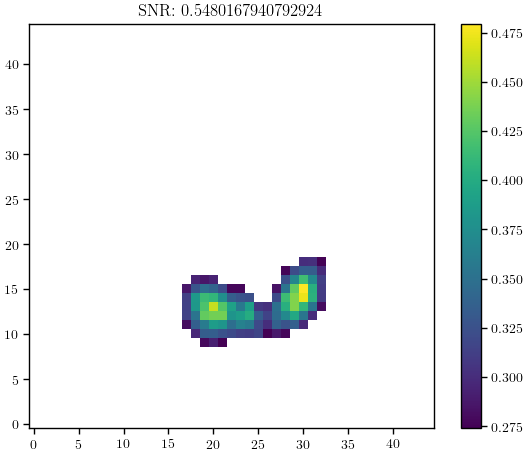

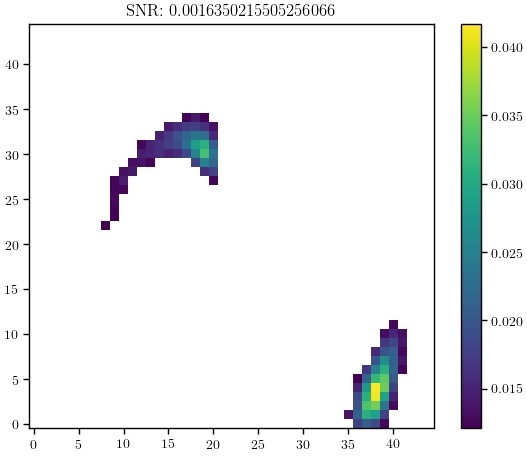

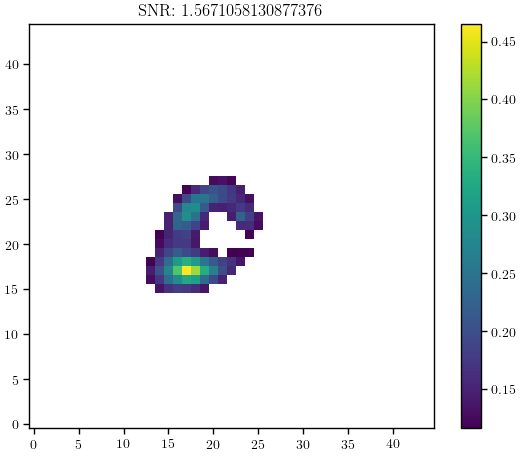

In [4]:
for snr, masked_array in zip(snr_list, snr_masked_array_list):
    plt.imshow(masked_array)
    plt.title(f'SNR: {snr}')
    plt.colorbar()
    plt.show()